# Oversampling Models Experiments

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Import data 

In [7]:
# Import 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import skopt

# Pre Processing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


# Balancing Classes
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import *
from imblearn.combine import SMOTEENN, SMOTETomek


# Metrics
from sklearn.metrics import *

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

# Ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

#Hyper para
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Warnings
from sklearn.utils._testing import ignore_warnings

import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 50)


from tensorflow import keras
import tensorflow as tf

In [8]:
# df festures dtypes
df_dtypes = {"PAYMENT_DAY":"category", "APPLICATION_SUBMISSION_TYPE":"category", "POSTAL_ADDRESS_TYPE":"category", "SEX":"category", "MARITAL_STATUS":"category",
             "STATE_OF_BIRTH":"category", "CITY_OF_BIRTH":"category", "NACIONALITY":"category",	"RESIDENCIAL_STATE":"category","RESIDENCIAL_CITY":"category",
             "RESIDENCIAL_BOROUGH":"category", "FLAG_RESIDENCIAL_PHONE":"category", "RESIDENCIAL_PHONE_AREA_CODE":"category", "RESIDENCE_TYPE":"category",
             "FLAG_EMAIL":"category", "FLAG_VISA":"category", "FLAG_MASTERCARD":"category",	"FLAG_DINERS":"category","FLAG_AMERICAN_EXPRESS":"category","FLAG_OTHER_CARDS":"category", 
             "QUANT_BANKING_ACCOUNTS":"category","QUANT_SPECIAL_BANKING_ACCOUNTS":"category","QUANT_CARS":"category","COMPANY":"category",
             "PROFESSIONAL_STATE":"category","FLAG_PROFESSIONAL_PHONE":"category","PROFESSIONAL_PHONE_AREA_CODE":"category","PROFESSION_CODE":"category","OCCUPATION_TYPE":"category",
             "PRODUCT":"category","RESIDENCIAL_ZIP_3":"category","PROFESSIONAL_ZIP_3":"category", "QUANT_DEPENDANTS":"category","AGE":"float64","total_cards" : "category", "TARGET_LABEL_BAD=1":"object",
             "MONTHS_IN_RESIDENCE":"category", "PERSONAL_MONTHLY_INCOME":"float", "OTHER_INCOMES":"category", "MONTHS_IN_THE_JOB":"category","PERSONAL_ASSETS_VALUE":"category"}

In [9]:
#Import DF
df = pd.read_csv(r"C:\Users\59898\Desktop\proyect\model\data\Clean_data\data01.csv",  encoding = "ISO-8859-1", sep = ",", dtype=df_dtypes, index_col = 0)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Split Data and Pipelines

In [10]:
# Mask to categorical and numeric columns
numerical_mask = (df.dtypes == "float64")
categorical_mask = (df.dtypes == "category")

# List with cat and num cols
numeric_cols  = df.columns[numerical_mask].tolist()
categorical_cols = df.columns[categorical_mask].tolist()

In [11]:
# Random Seed
seed = 123

# Split data into label and features
X = df.loc[:, df.columns != 'TARGET_LABEL_BAD=1']
y = df["TARGET_LABEL_BAD=1"].astype("int64")

# Train / test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = seed, stratify = y)
# Validation / Train Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = seed, stratify = y_train)

In [12]:
# Processing pipeline
num_transformer = Pipeline(
                            steps = [
                                        ("inputer", SimpleImputer(missing_values= np.nan,
                                                                  strategy = "median")),
                                        ("scaler", RobustScaler())
                                    ])
cat_transformer = Pipeline(
                            steps = [
                                        ("cat_inputer", SimpleImputer(missing_values= np.nan,
                                                                      strategy = "most_frequent")),
                                        ("encoder", OneHotEncoder(drop="if_binary",
                                                                  handle_unknown="ignore",
                                                                  sparse=False))
                                    ])

# Ensemble Transformers
pre_processor = ColumnTransformer(
                            transformers= [
                                        ("num", num_transformer, numeric_cols),
                                        ("cat", cat_transformer, categorical_cols)
                                        ],
                            verbose_feature_names_out = False)

In [13]:
# Apply  preprocessor to cat and num cols

# Train
X_pre_train = pre_processor.fit_transform(X= X_train)

# Validation
X_pre_val = pre_processor.transform(X=X_val)

# Test
X_pre_test = pre_processor.transform(X=X_test)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Evaluation tools

In [14]:
# Functions to evaluate models

def get_performance(predictions, y_test, classes=[0, 1]):
    
    report = classification_report(y_test, predictions, labels = classes, output_dict = True)
    
    return report


def plot_roc(model, y_test, features):
    # Put your code
    y_pred_probs = model.predict_proba(features)
    y_pred = y_pred_probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred)
    roc_auc = roc_auc_score(y_test,  y_pred)

    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})', linewidth=2.5)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#  Models

In [15]:
# Models

classifiers = {  "RF" : RandomForestClassifier(random_state = seed, n_estimators=100),
                 "SGD" : SGDClassifier(random_state = seed, loss = "log_loss", verbose = 0, max_iter  =100),
                 "XGB" : xgb.XGBClassifier( objective =  "binary:logistic", seed = seed,n_estimators = 100),
                 "CB" : CatBoostClassifier( loss_function='Logloss', random_seed = seed, silent = True, num_boost_round = 100),
                 "LGBM" : lgb.LGBMClassifier( random_state = seed, objective = "binary",   n_estimators=100), 
                 "ET" : ExtraTreesClassifier(random_state=seed, n_estimators=100),
}

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## No oversampling evaluation models

In [10]:
# AUC SCORES cv train without oversampling
for  classifier in classifiers:
        
    steps = [('model', classifiers[classifier])]

    pipeline = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
    scores = cross_val_score(pipeline, X_pre_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    
    print("ROC-AUC Score for", classifier,  "without over-sampling is", round(np.mean(scores),5))

ROC-AUC Score for RF without over-sampling is 0.62002
ROC-AUC Score for SGD without over-sampling is 0.62792
ROC-AUC Score for XGB without over-sampling is 0.62431
ROC-AUC Score for CB without over-sampling is 0.6273
ROC-AUC Score for LGBM without over-sampling is 0.63564
ROC-AUC Score for ET without over-sampling is 0.60199


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Oversampling Methods

In [16]:
# Oversampling Methods
over_methods = [
    ADASYN(random_state=7),
    BorderlineSMOTE(random_state=7),
    RandomOverSampler(random_state=7),
    SMOTE(random_state=7)
]

In [12]:
# Iterates over classifiers and over_methods
for classifier in classifiers:
    for method in over_methods:
        
        X_over, y_over = method.fit_resample(X_pre_train, y_train)

        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
        scores = cross_val_score(classifiers[classifier], X_over, y_over, scoring='roc_auc', cv=cv, n_jobs=-1)
    
        print("ROC-AUC Score for", classifier, "and", method, "is", round(np.mean(scores),5))

ROC-AUC Score for RF and ADASYN(random_state=7) is 0.92286
ROC-AUC Score for RF and BorderlineSMOTE(random_state=7) is 0.91074
ROC-AUC Score for RF and RandomOverSampler(random_state=7) is 0.95764
ROC-AUC Score for RF and SMOTE(random_state=7) is 0.91129
ROC-AUC Score for SGD and ADASYN(random_state=7) is 0.65097
ROC-AUC Score for SGD and BorderlineSMOTE(random_state=7) is 0.66318
ROC-AUC Score for SGD and RandomOverSampler(random_state=7) is 0.642
ROC-AUC Score for SGD and SMOTE(random_state=7) is 0.6603
ROC-AUC Score for XGB and ADASYN(random_state=7) is 0.87949
ROC-AUC Score for XGB and BorderlineSMOTE(random_state=7) is 0.87077
ROC-AUC Score for XGB and RandomOverSampler(random_state=7) is 0.75717
ROC-AUC Score for XGB and SMOTE(random_state=7) is 0.87044
ROC-AUC Score for CB and ADASYN(random_state=7) is 0.87463
ROC-AUC Score for CB and BorderlineSMOTE(random_state=7) is 0.86611
ROC-AUC Score for CB and RandomOverSampler(random_state=7) is 0.71966
ROC-AUC Score for CB and SMOTE(ra

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Combined Oversampling and undersampling Methods

In [13]:
# Combination of tecnicas
combinations = [
    SMOTEENN(random_state=7),
    SMOTETomek(random_state=7)
]

In [14]:
# Iterates over classifiers and combinations
for classifier in classifiers:
    for combination in combinations:
       
        X_over, y_over = combination.fit_resample(X_pre_train, y_train)

        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)
        scores = cross_val_score(classifiers[classifier], X_over, y_over, scoring='roc_auc', cv=cv)
    
        print("ROC-AUC Score for", classifier, "and", combination, "is", round(np.mean(scores),5))

ROC-AUC Score for RF and SMOTEENN(random_state=7) is 0.96638
ROC-AUC Score for RF and SMOTETomek(random_state=7) is 0.91397
ROC-AUC Score for SGD and SMOTEENN(random_state=7) is 0.77566
ROC-AUC Score for SGD and SMOTETomek(random_state=7) is 0.6624
ROC-AUC Score for XGB and SMOTEENN(random_state=7) is 0.94472
ROC-AUC Score for XGB and SMOTETomek(random_state=7) is 0.87182
ROC-AUC Score for CB and SMOTEENN(random_state=7) is 0.93922
ROC-AUC Score for CB and SMOTETomek(random_state=7) is 0.86792
ROC-AUC Score for LGBM and SMOTEENN(random_state=7) is 0.94568
ROC-AUC Score for LGBM and SMOTETomek(random_state=7) is 0.87669
ROC-AUC Score for ET and SMOTEENN(random_state=7) is 0.98338
ROC-AUC Score for ET and SMOTETomek(random_state=7) is 0.9413


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## SMOTEENN 

we can see that SMOTEENN give us the best values so we test that method with our models

In [15]:
# SMOTEENN X varibales
smoteenn  = SMOTEENN(random_state=7)
X_over_smtee, y_over_smotee = smoteenn.fit_resample(X_pre_train, y_train)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Models with the best oversampling combination performance scores

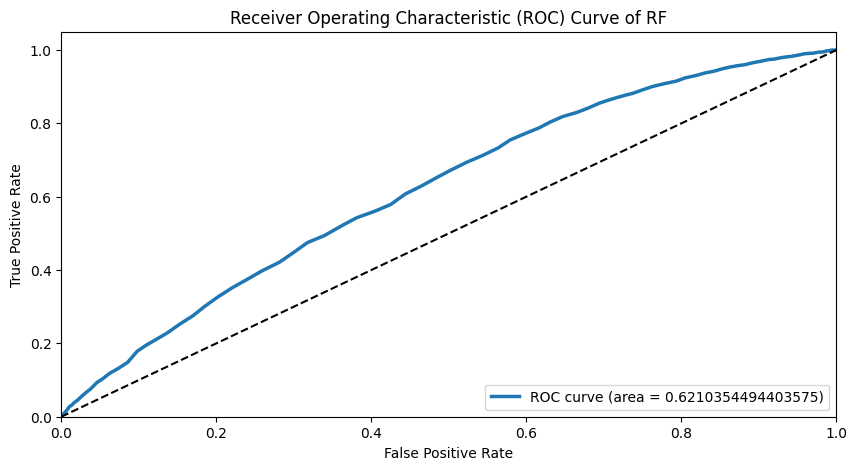

              precision    recall  f1-score   support

           0       0.83      0.40      0.54      6930
           1       0.31      0.77      0.45      2445

    accuracy                           0.50      9375
   macro avg       0.57      0.59      0.49      9375
weighted avg       0.70      0.50      0.52      9375



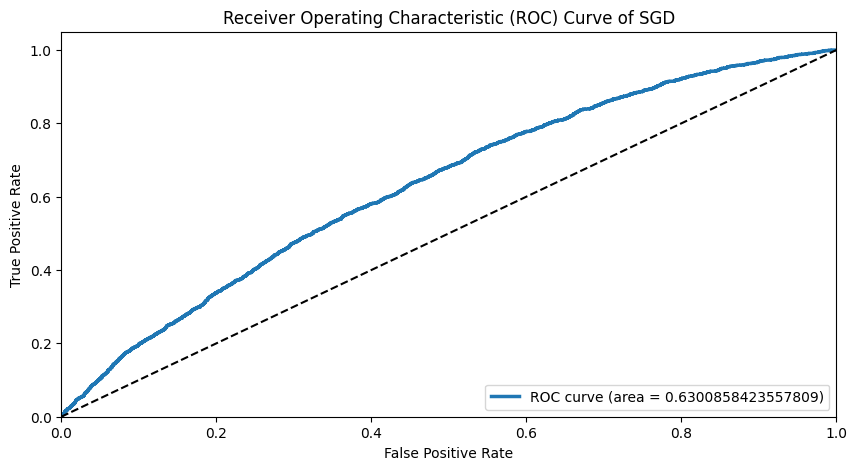

              precision    recall  f1-score   support

           0       0.86      0.25      0.39      6930
           1       0.29      0.89      0.44      2445

    accuracy                           0.42      9375
   macro avg       0.58      0.57      0.42      9375
weighted avg       0.71      0.42      0.40      9375



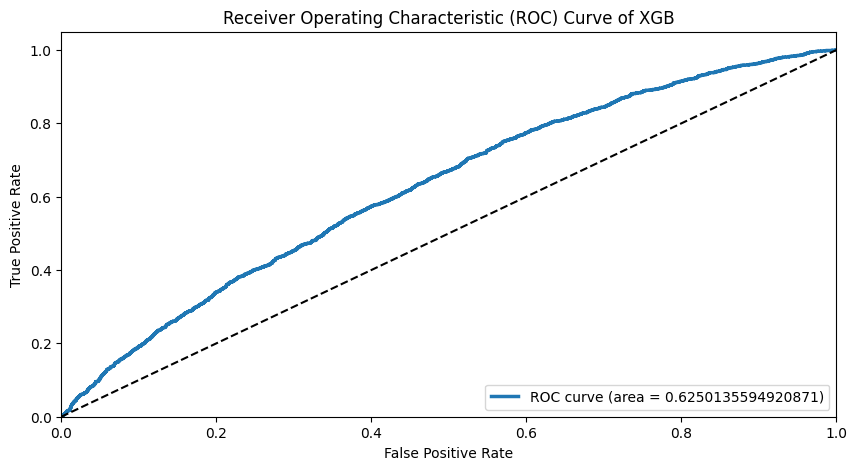

              precision    recall  f1-score   support

           0       0.81      0.48      0.61      6930
           1       0.32      0.69      0.44      2445

    accuracy                           0.54      9375
   macro avg       0.57      0.59      0.52      9375
weighted avg       0.69      0.54      0.56      9375



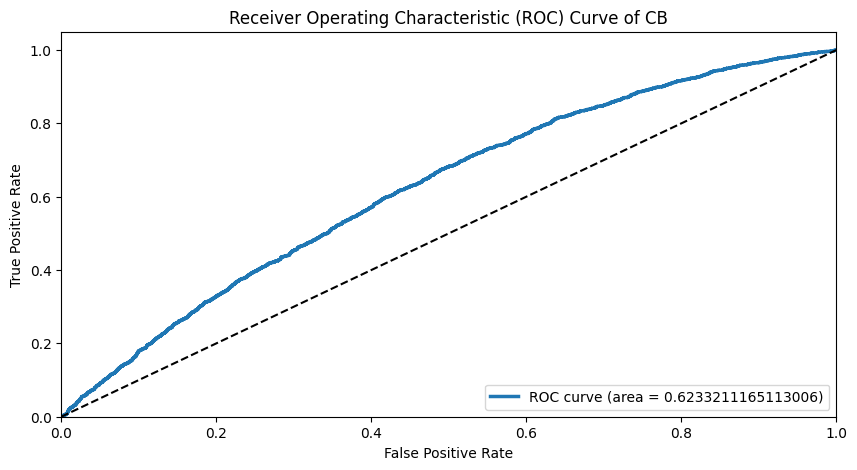

              precision    recall  f1-score   support

           0       0.82      0.48      0.60      6930
           1       0.32      0.71      0.44      2445

    accuracy                           0.54      9375
   macro avg       0.57      0.59      0.52      9375
weighted avg       0.69      0.54      0.56      9375



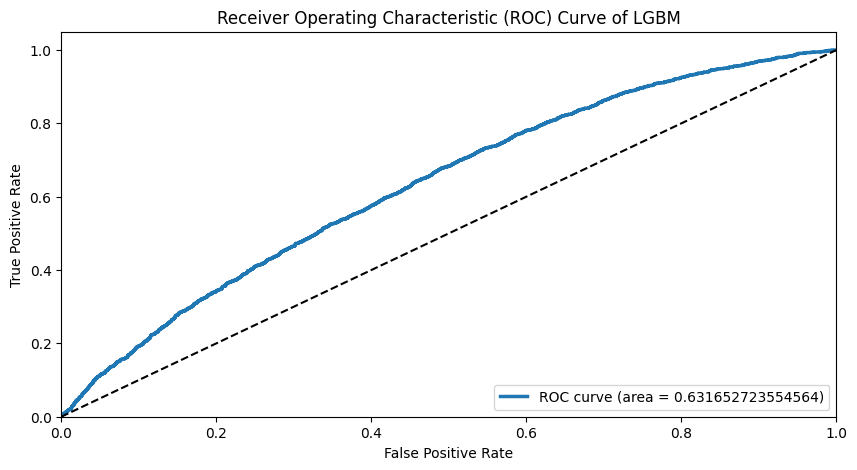

              precision    recall  f1-score   support

           0       0.82      0.47      0.60      6930
           1       0.32      0.71      0.44      2445

    accuracy                           0.54      9375
   macro avg       0.57      0.59      0.52      9375
weighted avg       0.69      0.54      0.56      9375



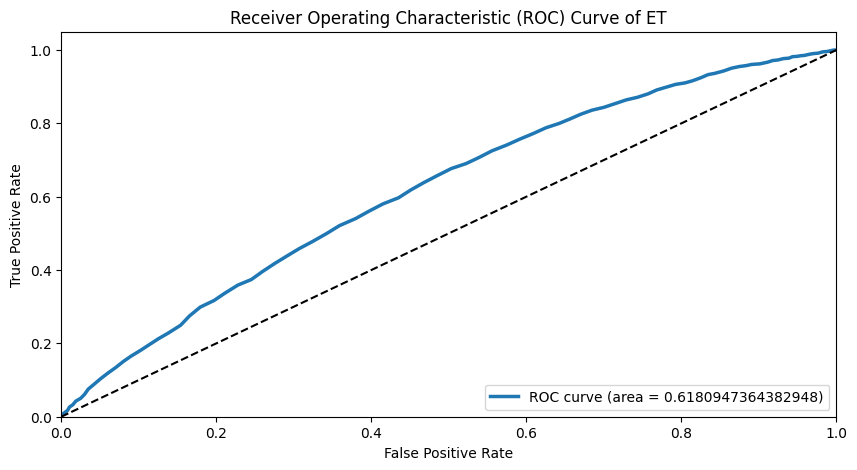

              precision    recall  f1-score   support

           0       0.83      0.41      0.55      6930
           1       0.31      0.76      0.44      2445

    accuracy                           0.50      9375
   macro avg       0.57      0.58      0.49      9375
weighted avg       0.69      0.50      0.52      9375



In [16]:
#  AUC score and Classification report of Models

for  classifier in classifiers:  
        
    steps = [('model', classifiers[classifier])]

    pipeline = Pipeline(steps=steps)

    pipeline.fit(X_over_smtee, y_over_smotee )
    
    y_predict  = pipeline.predict(X_pre_val)
    
    y_pred_probs = pipeline.predict_proba(X_pre_val)
    
    y_pred = y_pred_probs[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_val,  y_pred)
    
    roc_auc = roc_auc_score(y_val,  y_pred)

    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})', linewidth=2.5)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"Receiver Operating Characteristic (ROC) Curve of {classifier}")
    plt.legend(loc="lower right")
    plt.show()
    print(classification_report(y_val, y_predict, labels = [0, 1]))